In [1]:

from pathlib import Path
import pandas as pd
import numpy as np
import random 

import statsmodels.formula.api as sm
import math
from sklearn import linear_model

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline 

import datetime
import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
d = pd.read_csv('../data/raw_data.csv')
d_working = d.dropna(how='any')


### create numeric mapping for locations
unique_locs = d.location.value_counts().index.tolist()
loc_map = [x for x in range(len(unique_locs))]
loc_set = dict(zip(unique_locs, loc_map))
#loc_set

d_working['numeric_location'] = d_working['location'].map(lambda x: loc_set[x] if x in loc_set.keys() else -1)

### get dummies for locations
dum = pd.get_dummies(d_working['numeric_location'])
dum.columns = ['loc_%s' % (x) for x in dum.columns.tolist()]
d_working = pd.concat([d_working, dum], axis = 1)

### create week aggregates

def week_num(date_string):
    date = datetime.datetime.strptime(date_string,'%m/%d/%y')
    return datetime.date.isocalendar(date)[1]

d_working['week_number'] = d_working['date'].apply(week_num)

d_working.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,date,location,location_type,treatment,as_measured,amount_used,collector,google_second_wave_trend,google_drug_resistant_trend,stagger_second_wave_trend,...,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10,week_number
0,3/10/18,eca- front desk,gym,0.0,1594,0.0,Nikki,0,0,0,...,0,0,0,0,0,0,0,0,0,10
1,3/11/18,eca- front desk,gym,0.0,1583,11.0,Nikki,0,44,0,...,0,0,0,0,0,0,0,0,0,10
2,3/12/18,eca- front desk,gym,0.0,1573,10.0,Nikki,0,0,0,...,0,0,0,0,0,0,0,0,0,11
3,3/13/18,eca- front desk,gym,0.0,1566,7.0,Nikki,0,62,0,...,0,0,0,0,0,0,0,0,0,11
4,3/14/18,eca- front desk,gym,0.0,1549,17.0,Nikki,0,12,0,...,0,0,0,0,0,0,0,0,0,11


In [3]:

d_week = d_working.groupby(['week_number', 'treatment', 'numeric_location']).sum()
d_week.reset_index(inplace=True)
d_week = d_week[['week_number', 'treatment', 'numeric_location', 'amount_used',
       'google_second_wave_trend', 'google_drug_resistant_trend',
       'is_suspicious', 'stagger_second_wave_trend', 'stagger_drug_resistant_trend']]

loc_dum = pd.get_dummies(d_week['numeric_location'])
loc_dum.columns = ['loc_%s' % (x) for x in loc_dum.columns.tolist()]
d_week = pd.concat([d_week, loc_dum], axis = 1)

d_week.head()

,week_number,treatment,numeric_location,amount_used,google_second_wave_trend,google_drug_resistant_trend,is_suspicious,stagger_second_wave_trend,stagger_drug_resistant_trend,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10
0,10,0.0,0,4.0,0,52,0.0,0,52,1,0,0,0,0,0,0,0,0,0,0
1,10,0.0,1,11.0,0,44,0.0,0,39,0,1,0,0,0,0,0,0,0,0,0
2,10,0.0,2,73.0,0,139,0.0,0,115,0,0,1,0,0,0,0,0,0,0,0
3,10,0.0,3,53.0,0,139,0.0,0,115,0,0,0,1,0,0,0,0,0,0,0
4,10,0.0,10,4.0,0,44,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [6]:
d_week[d_week['numeric_location'] == 0]

,week_number,treatment,numeric_location,amount_used,google_second_wave_trend,google_drug_resistant_trend,is_suspicious,stagger_second_wave_trend,stagger_drug_resistant_trend,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10
0,10,0.0,0,4.0,0,52,0.0,0,52,1,0,0,0,0,0,0,0,0,0,0
5,11,0.0,0,2.0,0,179,0.0,0,208,1,0,0,0,0,0,0,0,0,0,0
16,12,0.0,0,1.0,0,179,0.0,0,194,1,0,0,0,0,0,0,0,0,0,0
26,13,0.0,0,1.0,366,310,0.0,366,294,1,0,0,0,0,0,0,0,0,0,0
36,14,0.0,0,0.0,31,39,0.0,38,0,1,0,0,0,0,0,0,0,0,0,0
42,14,1.0,0,11.0,15,262,0.0,46,271,1,0,0,0,0,0,0,0,0,0,0


In [13]:
### step 1: look at each location's first (control week's) weeks average and compare to their first treatment average
d_week.groupby(['numeric_location','week_number', 'treatment']).mean()[['google_second_wave_trend', 'amount_used']]

google_second_wave_trend  amount_used
numeric_location week_number treatment                                       
0                10          0.0                               0          4.0
                 11          0.0                               0          2.0
                 12          0.0                               0          1.0
                 13          0.0                             366          1.0
                 14          0.0                              31          0.0
                             1.0                              15         11.0
1                10          0.0                               0         11.0
                 11          0.0                               0         82.0
                 12          1.0                               0         86.0
                 13          1.0                             404         82.0
                 14          0.0                              15         43.0
                             1.0                              31         10.0
2                10          0.0                               0         73.0
                 11          1.0                               0        109.0
                 12          0.0                               0         53.0
                 13          1.0                             366         52.0
3                10          0.0                               0         53.0
                 11          0.0                               0         44.0
                 12          1.0                               0         72.0
                 13          0.0                             366        225.0
4                11          0.0                               0         15.0
                 12          1.0                               0         10.0
                 13          1.0                             366          3.0
                 14          0.0                              46          5.0
5                11          0.0                               0         68.0
                 12          0.0                               0         26.0
                 13          0.0                             366         25.0
                 14          1.0                              46         32.0
6                11          0.0                               0         23.0
                 12          0.0                               0         29.0
                 14          1.0                              46         43.0
                 15          0.0                              16         28.0
7                11          0.0                               0         48.0
                 12          1.0                               0         17.0
                 13          1.0                             366        291.0
                 14          0.0                              46       -149.0
8                11          0.0                               0          5.0
                 12          0.0                               0         18.0
                 13          0.0                             366         10.0
                 14          1.0                              46          4.0
9                11          0.0                               0         50.0
                 12          1.0                               0         37.0
                 13          1.0                             366         65.0
                 14          0.0                              46        216.0
10               10          0.0                               0          4.0
                 11          0.0                               0         13.0
                 13          1.0                              38          7.0
                 14          0.0                               0          4.0

In [26]:
### can we see a difference between weeks given we drop meansurement and sabotage errors?
d_working[d_working['amount_used'] >=0].groupby( \
    ['numeric_location','week_number', 'treatment']).mean() \
    [['amount_used', 'google_second_wave_trend']]

amount_used  google_second_wave_trend
numeric_location week_number treatment                                       
0                10          0.0           1.333333                  0.000000
                 11          0.0           0.333333                  0.000000
                 12          0.0           0.166667                  0.000000
                 13          0.0           0.166667                 61.000000
                 14          0.0           0.000000                 31.000000
                             1.0           2.200000                  3.000000
1                10          0.0           5.500000                  0.000000
                 11          0.0          11.714286                  0.000000
                 12          1.0          12.285714                  0.000000
                 13          1.0          11.714286                 57.714286
                 14          0.0          10.750000                  3.750000
                             1.0          10.000000                 31.000000
2                10          0.0          14.600000                  0.000000
                 11          1.0          21.800000                  0.000000
                 12          0.0          10.600000                  0.000000
                 13          1.0          10.400000                 73.200000
3                10          0.0          10.600000                  0.000000
                 11          0.0           8.800000                  0.000000
                 12          1.0          14.400000                  0.000000
                 13          0.0          45.000000                 73.200000
4                11          0.0           3.000000                  0.000000
                 12          1.0           3.500000                  0.000000
                 13          1.0           1.000000                 66.500000
                 14          0.0           1.500000                  3.750000
5                11          0.0          17.500000                  0.000000
                 12          0.0           5.200000                  0.000000
                 13          0.0           5.000000                 73.200000
                 14          1.0           6.400000                  9.200000
6                11          0.0           4.600000                  0.000000
                 12          0.0           5.800000                  0.000000
                 14          1.0           8.600000                  9.200000
                 15          0.0           5.600000                  3.200000
7                11          0.0          12.000000                  0.000000
                 12          1.0           4.500000                  0.000000
                 13          1.0          58.200000                 73.200000
                 14          0.0           4.000000                  5.000000
8                11          0.0           1.250000                  0.000000
                 12          0.0           3.600000                  0.000000
                 13          0.0           2.000000                 73.200000
                 14          1.0           2.000000                  5.000000
9                11          0.0          12.500000                  0.000000
                 12          1.0          18.500000                  0.000000
                 13          1.0          13.000000                 73.200000
                 14          0.0          43.200000                  9.200000
10               10          0.0           4.000000                  0.000000
                 11          0.0          13.000000                  0.000000
                 13          1.0           7.000000                 38.000000
                 14          0.0           4.000000                  0.000000

In [41]:
### can we see a difference between weeks given we drop all suspicious elements?
a = d_working[d_working['is_suspicious'] ==0].groupby( \
    ['numeric_location','week_number', 'treatment']).mean() \
    [['amount_used', 'google_second_wave_trend']]
a

amount_used  google_second_wave_trend
numeric_location week_number treatment                                       
0                10          0.0           1.333333                  0.000000
                 11          0.0           0.333333                  0.000000
                 12          0.0           0.166667                  0.000000
                 13          0.0           0.166667                 61.000000
                 14          0.0           0.000000                 31.000000
                             1.0           2.200000                  3.000000
1                10          0.0           5.500000                  0.000000
                 11          0.0          11.714286                  0.000000
                 12          1.0          12.285714                  0.000000
                 13          1.0          11.714286                 57.714286
                 14          0.0          10.750000                  3.750000
                             1.0          10.000000                 31.000000
2                10          0.0          14.600000                  0.000000
                 11          1.0          21.800000                  0.000000
                 12          0.0          10.600000                  0.000000
                 13          1.0          10.400000                 73.200000
3                10          0.0          10.600000                  0.000000
                 11          0.0           8.800000                  0.000000
                 12          1.0          14.400000                  0.000000
                 13          0.0           5.500000                 75.750000
4                11          0.0           3.000000                  0.000000
                 12          1.0           3.500000                  0.000000
                 13          1.0           1.000000                 66.500000
                 14          0.0           1.500000                  3.750000
5                11          0.0          17.500000                  0.000000
                 12          0.0           5.200000                  0.000000
                 13          0.0           5.000000                 73.200000
                 14          1.0           6.400000                  9.200000
6                11          0.0           4.600000                  0.000000
                 12          0.0           5.800000                  0.000000
                 14          1.0           8.600000                  9.200000
                 15          0.0           5.600000                  3.200000
7                11          0.0          12.000000                  0.000000
                 12          1.0           4.500000                  0.000000
                 13          1.0           4.500000                 80.000000
                 14          0.0           4.000000                  5.000000
8                11          0.0           1.250000                  0.000000
                 12          0.0           3.600000                  0.000000
                 13          0.0           2.000000                 73.200000
                 14          1.0           2.000000                  5.000000
9                11          0.0          12.500000                  0.000000
                 12          1.0          18.500000                  0.000000
                 13          1.0          13.000000                 73.200000
                 14          0.0          16.000000                 11.500000
10               10          0.0           4.000000                  0.000000
                 11          0.0          13.000000                  0.000000
                 13          1.0           7.000000                 38.000000
                 14          0.0           4.000000                  0.000000

In [34]:
a.to_csv('../data/location_aggregates_by_week.csv', sep = ',')

In [43]:
d_working[d_working['is_suspicious'] ==0].groupby( \
    ['numeric_location','treatment']).describe() \
    ['amount_used']

count       mean        std  min    25%   50%  \
numeric_location treatment                                                  
0                0.0         22.0   0.363636   0.726731  0.0   0.00   0.0   
                 1.0          5.0   2.200000   1.643168  0.0   1.00   3.0   
1                0.0         13.0  10.461538   5.348137  0.0   7.00  11.0   
                 1.0         15.0  11.866667   8.322660  2.0   6.00  10.0   
2                0.0         10.0  12.600000   6.535374  4.0   9.00  11.0   
                 1.0         10.0  16.100000   9.386160  5.0   9.50  15.0   
3                0.0         14.0   8.500000   3.568020  2.0   6.00   9.0   
                 1.0          5.0  14.400000   4.505552  9.0  12.00  13.0   
4                0.0          9.0   2.333333   2.645751  0.0   1.00   1.0   
                 1.0          8.0   2.250000   2.764572  1.0   1.00   1.0   
5                0.0         14.0   8.642857  14.721032  1.0   3.00   6.0   
                 1.0          5.0   6.400000   2.607681  4.0   4.00   6.0   
6                0.0         15.0   5.333333   2.497618  1.0   4.00   5.0   
                 1.0          5.0   8.600000   3.209361  4.0   7.00   9.0   
7                0.0          7.0   8.571429  13.239551  0.0   2.50   5.0   
                 1.0          8.0   4.500000   3.854496  0.0   2.50   3.0   
8                0.0         14.0   2.357143   1.736803  0.0   1.00   2.0   
                 1.0          3.0   2.000000   1.000000  1.0   1.50   2.0   
9                0.0          8.0  14.250000  12.589678  5.0   6.75   9.0   
                 1.0          7.0  14.571429   8.462804  6.0   7.00  12.0   
10               0.0          3.0   7.000000   5.196152  4.0   4.00   4.0   
                 1.0          1.0   7.000000        NaN  7.0   7.00   7.0   

                              75%   max  
numeric_location treatment               
0                0.0         0.00   2.0  
                 1.0         3.00   4.0  
1                0.0        16.00  17.0  
                 1.0        16.00  34.0  
2                0.0        16.25  27.0  
                 1.0        21.50  34.0  
3                0.0        10.00  14.0  
                 1.0        18.00  20.0  
4                0.0         3.00   8.0  
                 1.0         2.00   9.0  
5                0.0         6.75  59.0  
                 1.0         8.00  10.0  
6                0.0         7.00  10.0  
                 1.0        11.00  12.0  
7                0.0         6.00  38.0  
                 1.0         6.75  11.0  
8                0.0         3.75   6.0  
                 1.0         2.50   3.0  
9                0.0        17.25  43.0  
                 1.0        22.50  25.0  
10               0.0         8.50  13.0  
                 1.0         7.00   7.0

In [44]:
### define a TSA set: remove all suspicious line items
from statsmodels.tsa.api import VAR, DynamicVAR

d_tsa = d_working[d_working['is_suspicious'] ==0]

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [66]:
d_tsa.head()

,date,location,location_type,treatment,as_measured,amount_used,collector,google_second_wave_trend,google_drug_resistant_trend,stagger_second_wave_trend,...,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10,week_number
0,3/10/18,eca- front desk,gym,0.0,1594,0.0,Nikki,0,0,0,...,0,0,0,0,0,0,0,0,0,10
1,3/11/18,eca- front desk,gym,0.0,1583,11.0,Nikki,0,44,0,...,0,0,0,0,0,0,0,0,0,10
2,3/12/18,eca- front desk,gym,0.0,1573,10.0,Nikki,0,0,0,...,0,0,0,0,0,0,0,0,0,11
3,3/13/18,eca- front desk,gym,0.0,1566,7.0,Nikki,0,62,0,...,0,0,0,0,0,0,0,0,0,11
4,3/14/18,eca- front desk,gym,0.0,1549,17.0,Nikki,0,12,0,...,0,0,0,0,0,0,0,0,0,11


In [75]:
d_tsa.columns

Index(['date', 'location', 'location_type', 'treatment', 'as_measured',
       'amount_used', 'collector', 'google_second_wave_trend',
       'google_drug_resistant_trend', 'stagger_second_wave_trend',
       'stagger_drug_resistant_trend', 'is_suspicious', 'numeric_location',
       'loc_0', 'loc_1', 'loc_2', 'loc_3', 'loc_4', 'loc_5', 'loc_6', 'loc_7',
       'loc_8', 'loc_9', 'loc_10', 'week_number'],
      dtype='object')

In [67]:
### the variability in this set is really high within subject, run a power analysis to see 
### how many data points we actually need to dampen down the noise
### inspiration http://www.djmannion.net/psych_programming/data/power/power.html

import scipy.stats as stats

days_per_group = 30


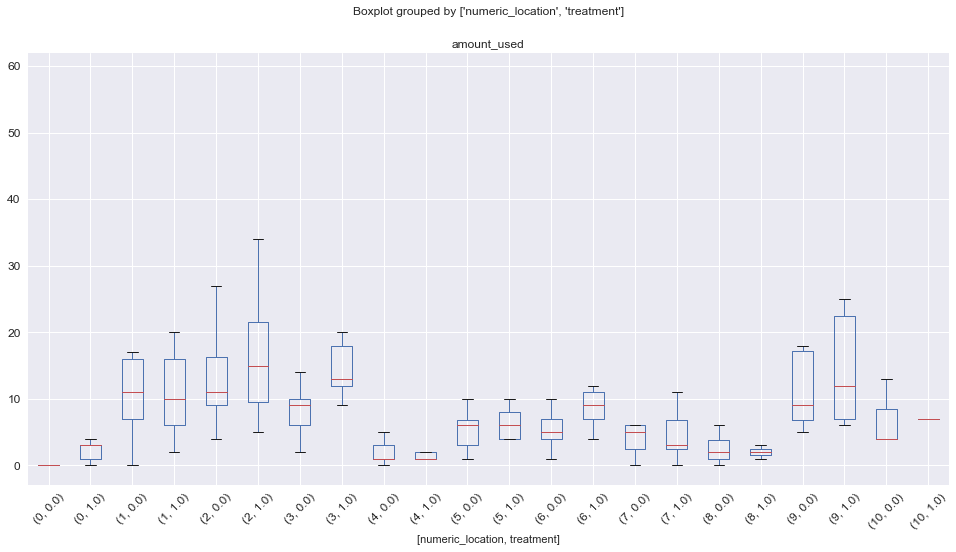

In [86]:
d_tsa.boxplot('amount_used', by= ['numeric_location', 'treatment'], rot=45, fontsize =12, figsize = (16,8))

In [258]:
### find the power of our experiment per location
import scipy.stats

d_tsa = d_working[d_working['is_suspicious'] ==0]


def find_power(loc, sims):
    """
    for a given numeric location, return the power of the set
    """
    d_test = d_tsa[d_tsa['numeric_location']  == loc]
    treat_group = d_test[d_test['treatment'] == 1]['amount_used']
    ctrl_group = d_test[d_test['treatment'] == 0]['amount_used']
    n_per_group = int(np.ceil(np.mean([treat_group.shape[0],ctrl_group.shape[0]])))
    treat_mean = treat_group.mean()
    ctrl_mean = ctrl_group.mean()
    group_means = [treat_mean, ctrl_mean]
    treat_sigma = treat_group.std()
    ctrl_sigma = ctrl_group.std()
    group_sigmas = [treat_sigma, ctrl_sigma]
    ### number of simulations
    n_sims = sims
    ###store p val for each simulation
    sim_p = np.empty(n_sims)
    sim_p.fill(np.nan)

    for i_sim in range(n_sims):

        data = np.empty([n_per_group, n_groups])
        data.fill(np.nan)

        # simulate the data for this 'experiment'
        for i_group in range(n_groups):

            data[:, i_group] = np.random.normal(
                loc=group_means[i_group],
                scale=group_sigmas[i_group],
                size=n_per_group
            )

        result = scipy.stats.ttest_ind(data[:, 0], data[:, 1])

        sim_p[i_sim] = result[1]

    # number of simulations where the null was rejected
    n_rej = np.sum(sim_p < 0.05)

    prop_rej = n_rej / float(n_sims)

    print("Power for %s location: %s\n \
           \ttreatment mean, sigma: %s, %s\n \
           \tcontrol mean, sigma: %s, %s\n " \
          % (d_test['location'].iloc[0],prop_rej, round(treat_mean,2), round(treat_sigma,2), round(ctrl_mean,2), round(ctrl_sigma,2))) 
    return


for i in range(len(loc_set)):

    find_power(i, 10000)
    
    

Power for yarn shop location: 0.9568
            	treatment mean, sigma: 2.2, 1.64
            	control mean, sigma: 0.36, 0.73
 
Power for eca- front desk location: 0.0879
            	treatment mean, sigma: 11.87, 8.32
            	control mean, sigma: 10.46, 5.35
 
Power for ped- not well location: 0.1558
            	treatment mean, sigma: 16.1, 9.39
            	control mean, sigma: 12.6, 6.54
 
Power for ped - well location: 0.8667
            	treatment mean, sigma: 14.4, 4.51
            	control mean, sigma: 8.5, 3.57
 
Power for concur - 3rd floor location: 0.0502
            	treatment mean, sigma: 2.25, 2.76
            	control mean, sigma: 2.33, 2.65
 
Power for concur - 16th floor location: 0.0834
            	treatment mean, sigma: 6.4, 2.61
            	control mean, sigma: 8.64, 14.72
 
Power for Avalon - Gym location: 0.6738
            	treatment mean, sigma: 8.6, 3.21
            	control mean, sigma: 5.33, 2.5
 
Power for concur -12th floor location: 0.1408
      

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less


In [246]:
def find_sample_required(location, sims, desired_power):
    """ find the number of days required for each location to 
    see a statistically significant difference in control vs mean"""
    
    d_test = d_tsa[d_tsa['numeric_location']  == location]
    treat_group = d_test[d_test['treatment'] == 1]['amount_used']
    ctrl_group = d_test[d_test['treatment'] == 0]['amount_used']
    
    treat_mean = treat_group.mean()
    ctrl_mean = ctrl_group.mean()
    group_means = [treat_mean, ctrl_mean]
    treat_sigma = treat_group.std()
    ctrl_sigma = ctrl_group.std()
    group_sigmas = [treat_sigma, ctrl_sigma]

    # start at 30 days each
    n_per_group = 30



    n_groups = len(group_means)

    # number of simulations
    n_sims = sims

    # power level that we would like to reach
    desired_power = desired_power

    # initialise the power for the current sample size to a small value
    current_power = 0.0
    res_statement = []
    # keep iterating until desired power is obtained
    while current_power < desired_power:

        data = np.empty([n_sims, n_per_group, n_groups])
        data.fill(np.nan)

        for i_group in range(n_groups):

            data[:, :, i_group] = np.random.normal(
                loc=group_means[i_group],
                scale=group_sigmas[i_group],
                size=[n_sims, n_per_group])

        result = scipy.stats.ttest_ind(
            data[:, :, 0],
            data[:, :, 1],
            axis=1)

        sim_p = result[1]

        # number of simulations where the null was rejected
        n_rej = np.sum(sim_p < 0.05)

        prop_rej = n_rej / float(n_sims)

        current_power = prop_rej

        res_statement.append("With {n:d} days per group in {s} location, power = {p:.3f}".format(
            n=n_per_group,
            p=current_power,
            s=d_test['location'].iloc[0]
        ))

        # increase the number of samples by one for the next iteration of the loop
        n_per_group+=1
    return print(res_statement[-1])

for i in range(len(loc_set)):

    find_sample_required(i, 5000, 0.8)

With 30 days per group in yarn shop location, power = 1.000
With 390 days per group in eca- front desk location, power = 0.816
With 85 days per group in ped- not well location, power = 0.800
With 30 days per group in ped - well location, power = 1.000


KeyboardInterrupt: 

In [250]:
find_sample_required(5, 2500, 0.8)

With 343 days per group in concur - 16th floor location, power = 0.800


In [251]:
find_sample_required(6, 2500, 0.8)

With 30 days per group in Avalon - Gym location, power = 0.994


In [252]:
find_sample_required(7, 2500, 0.8)

With 92 days per group in concur -12th floor location, power = 0.801


In [253]:
find_sample_required(8, 2500, 0.8)

With 245 days per group in concur - 10th floor location, power = 0.800


In [254]:
find_sample_required(9, 2500, 0.8)

KeyboardInterrupt: 

In [255]:
find_sample_required(10, 2500, 0.8)

/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less


KeyboardInterrupt: 

In [ ]:
find_sample_required(11, 2500, 0.8)

In [52]:
### tutorial from the TSA documentation
### doesn't meet our use case because the VAR model doesn't accept 2-d arrays
### so treatment/control cannot be modeled.

dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
from statsmodels.tsa.base.datetools import dates_from_str

quarterly = dates_from_str(quarterly)
mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pd.DatetimeIndex(quarterly)

data = np.log(mdata).diff().dropna()
data

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694
1960-09-30,0.001633,-0.003968,-0.005978
1960-12-31,-0.012906,0.001343,-0.131852
1961-03-31,0.005923,-0.000280,0.025244
1961-06-30,0.018535,0.014770,0.071834
1961-09-30,0.016032,0.004839,0.080453


In [56]:
mdata

,realgdp,realcons,realinv
1959-03-31,2710.349,1707.4,286.898
1959-06-30,2778.801,1733.7,310.859
1959-09-30,2775.488,1751.8,289.226
1959-12-31,2785.204,1753.7,299.356
1960-03-31,2847.699,1770.5,331.722
1960-06-30,2834.390,1792.9,298.152
1960-09-30,2839.022,1785.8,296.375
1960-12-31,2802.616,1788.2,259.764
1961-03-31,2819.264,1787.7,266.405
1961-06-30,2872.005,1814.3,286.246


In [57]:
model = VAR(data)

In [62]:
res = model.fit(1)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


In [63]:
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, Apr, 2018
Time:                     15:20:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.7388
Nobs:                     201.000    HQIC:                  -27.8562
Log likelihood:           1963.94    FPE:                7.37174e-13
AIC:                     -27.9360    Det(Omega_mle):     6.94859e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.003580         0.000911            3.928           0.000
L1.realgdp         -0.338056         0.172084           -1.964           0.051
L1.realcons         0.746283         0.130411            5.723    

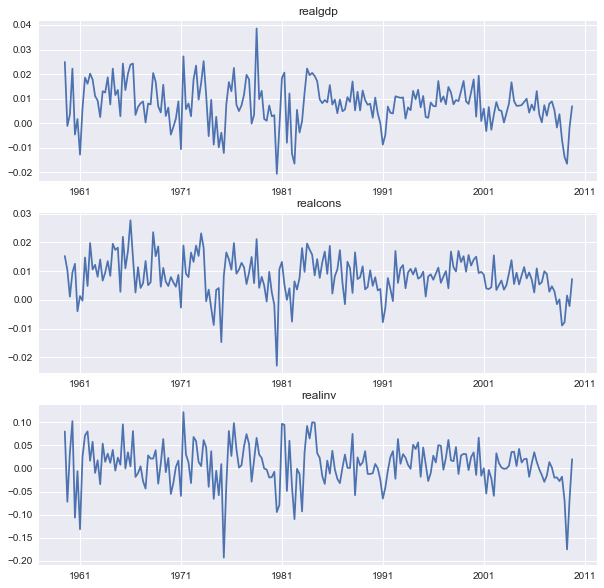

In [64]:
res.plot()

,week_number,treatment,numeric_location,amount_used,google_second_wave_trend,google_drug_resistant_trend,is_suspicious,stagger_second_wave_trend,stagger_drug_resistant_trend,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10
0,10,0.0,0,4.0,0,52,0.0,0,52,1,0,0,0,0,0,0,0,0,0,0
1,10,0.0,1,11.0,0,44,0.0,0,39,0,1,0,0,0,0,0,0,0,0,0
2,10,0.0,2,73.0,0,139,0.0,0,115,0,0,1,0,0,0,0,0,0,0,0
3,10,0.0,3,53.0,0,139,0.0,0,115,0,0,0,1,0,0,0,0,0,0,0
4,10,0.0,10,4.0,0,44,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,11,0.0,0,2.0,0,179,0.0,0,208,1,0,0,0,0,0,0,0,0,0,0
6,11,0.0,1,82.0,0,194,0.0,0,223,0,1,0,0,0,0,0,0,0,0,0
7,11,0.0,3,44.0,0,164,0.0,0,143,0,0,0,1,0,0,0,0,0,0,0
8,11,0.0,4,15.0,0,164,0.0,0,143,0,0,0,0,1,0,0,0,0,0,0
9,11,0.0,5,68.0,0,164,1.0,0,143,0,0,0,0,0,1,0,0,0,0,0
